# Class 3: Regularization: Ridge and Lasso

 <a href="https://colab.research.google.com/github/fdiaz1968/ML-Course/blob/main/docs/clase3_regularizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Google Colab

The following is required if we are runing the code in Colab.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading required packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

## Importing the Data

Read the healthcare dataset file. Run the first line if running on Google Colab,
and the second one if running locally.

In [4]:

# data = pd.read_csv("/content/drive/MyDrive/MIT Machine Learning/Week_4/Codes and Data/healthcare_data.csv")
data = pd.read_csv('G:\My Drive\Cursos_USM\Supervised Machine Learning\Data\healthcare_data.csv')

In [5]:
# Copying data to another variable to avoid any changes to original data
same_data = data.copy()

Let´s briefly review our data set.

In [6]:
# Checking the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  500000 non-null  int64  
 1   Department                         500000 non-null  object 
 2   Ward_Facility_Code                 500000 non-null  object 
 3   doctor_name                        500000 non-null  object 
 4   staff_available                    500000 non-null  int64  
 5   patientid                          500000 non-null  int64  
 6   Age                                500000 non-null  object 
 7   gender                             500000 non-null  object 
 8   Type of Admission                  500000 non-null  object 
 9   Severity of Illness                500000 non-null  object 
 10  health_conditions                  348112 non-null  object 
 11  Visitors with Patient              5000

Again, we drop *patientid* from the data as it is an identifier and will not add value to the analysis.

In [7]:
data=data.drop(columns=["patientid"])

We double check that there are no duplicates.

In [8]:
data.duplicated().sum()

0

In [9]:
# List of all important categorical variables
# cat_col = ["Department", "Type of Admission", 'Severity of Illness', 'gender', 'Insurance', 'health_conditions', 'doctor_name', "Ward_Facility_Code", "Age"]


## Data Preparation for Model Building

- Before we proceed to build a model, we'll have to encode categorical features.
- Separate the independent variables and dependent Variables.
- We'll split the data into train and test to be able to evaluate the model that we train on the training data.

In [10]:
# Creating dummy variables for the categorical columns
# drop_first=True is used to avoid redundant variables
data = pd.get_dummies(
    data,
    columns = data.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)

Let's check the data after handling categorical data:

In [11]:
data

,Available Extra Rooms in Hospital,staff_available,Visitors with Patient,Admission_Deposit,Stay (in days),Department_anesthesia,Department_gynecology,Department_radiotherapy,Department_surgery,Ward_Facility_Code_B,Ward_Facility_Code_C,Ward_Facility_Code_D,Ward_Facility_Code_E,Ward_Facility_Code_F,doctor_name_Dr John,doctor_name_Dr Mark,doctor_name_Dr Nathan,doctor_name_Dr Olivia,doctor_name_Dr Sam,doctor_name_Dr Sarah,doctor_name_Dr Simon,doctor_name_Dr Sophia,Age_11-20,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100,gender_Male,gender_Other,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Minor,Severity of Illness_Moderate,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_Other,Insurance_Yes
0,4,0,4,2966.408696,8,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
1,4,2,2,3554.835677,9,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False
2,2,8,2,5624.733654,7,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
3,4,7,4,4814.149231,8,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False
4,2,10,2,5169.269637,34,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,4,2,3,4105.795901,10,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False
499996,13,8,2,4631.550257,11,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
499997,2,3,2,5456.930075,8,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
499998,2,1,2,4694.127772,23,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False


Separating independent variables and the target variable:

In [12]:
x = data.drop('Stay (in days)',axis=1)
y = data['Stay (in days)']

We will use the **train_test_split** function from the *sklearn.model_selection* module of *scikit-learn*, a popular machine learning library in Python. This function is commonly used to split a dataset into random train and test subsets, which is a crucial step in the machine learning workflow for evaluating the performance of algorithms on unseen data (https://scikit-learn.org/stable/)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

Checking the shape of the train and test data

In [14]:
# Checking the shape of the train and test data
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)

Shape of Training set :  (400000, 41)
Shape of test set :  (100000, 41)


## Metrics for Model Evaluation

* We will be using different metrics functions defined in sklearn like RMSE, MAE, 𝑅2, Adjusted 𝑅2, and MAPE for regression models evaluation. We will define a function to calculate these metrics.


In [15]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

## Linear Regression Model (LRM)

We will quikly review the LRM, but instead of using the *statsmodels.api*, we will import the **LinearRegression** class from the linear_model module within the scikit-learn library. 

In [16]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(x_train, y_train)

print("Coefficients: ", model.coef_)

Coefficients:  [ 7.86011825e-02 -9.24581600e-04  2.16032581e-04 -3.83898869e-05
  6.08222762e+00 -3.97322274e+00 -4.62163474e+00  6.87675974e+00
 -1.22173775e+00  4.34865964e-01 -1.27546790e+00  3.08405364e-01
 -1.47601709e+00  2.38041577e-01 -1.61513502e+00 -1.32145112e+00
 -1.46811850e+00 -1.52644356e+00 -2.90889364e-01  1.94492630e+00
 -8.92763759e-01 -1.27377868e+01 -1.04829928e+01 -1.34354610e+01
 -1.35113333e+01 -3.66513882e-01 -4.21693414e-01 -2.19302475e-01
 -1.74421929e-02 -2.59854742e-01  1.79025487e+00 -2.57292828e-02
 -6.66988605e-02  1.50153511e-01  4.31961072e-02  9.87477156e-02
 -3.51239328e-01  5.94307858e-01 -3.66904398e-02  6.50726787e-03
 -1.06540417e-02]


By executing `model = LinearRegression()`, we have instantiated the **LinearRegression** class, creating an object named model which represents our linear regression model. In other words, `model = LinearRegression()` creates an **instance** of the LinearRegression class.  This model can now be trained on a dataset comprising of features (independent variables) and a target (dependent variable) to learn the relationship between them.

## Performance of the Model in the Train Data and in the Test Data

Checking the performance of the model on the training data:

In [17]:
linear_reg = model_performance_regression(model, x_train, y_train)
linear_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135093,2.146244,0.842813,0.842796,19.591833


Checking the performance of the estimated model on the testing data:

In [18]:
linear_reg_test = model_performance_regression(model, x_test, y_test)
linear_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842964,19.676966


**Observations**:

-The Root Mean Squared Error and the adjusted $R^2$ of train and test data arevery close, indicating thatour model is not overfitting to the training data.

## Model Complexity 

**Regularization** is a fundamental concept in statistical learning and machine learning that aims to prevent overfitting by introducing additional information or constraints into the model. 

* Overfitting occurs when a model learns the **noise** in the training data to the extent that it performs poorly on unseen data. 

* Regularization addresses this problem by adding a penalty on the size of the coefficients in the model, effectively adding a bias to reduce variance. In other words, this technique relies on the **bias-variance** trade-off to avoid overfitting (https://towardsdatascience.com/what-is-bias-variance-tradeoff-c8b19772e054).


## Model Complexity

In the context of statistical learning and machine learning, a complex model refers to a model with a high level of flexibility due to having a large number of parameters or features, which allows it to fit a wide variety of shapes and patterns in the data (https://www.sciencedirect.com/topics/computer-science/model-complexity). The complexity of a model is closely related to its capacity to learn from data; a more complex model can capture more detailed information and subtleties in the data, potentially leading to better performance on the training data.

The complexity of a model is influenced by several factors:

* Number of Parameters: A model with more parameters (e.g., a polynomial regression model of a high degree) can adjust more to fit the training data closely.

* Model Structure: Certain types of models are inherently more complex. For example, deep neural networks with many layers and nodes can capture more complex patterns than a single-layer perceptron.

* Feature Space: The number of features or predictors used in the model also contributes to its complexity. More features can allow a model to capture more information about the data, but they also increase the risk of overfitting.

* Interaction and Polynomial Terms: Models that include interaction terms (products of features) or polynomial terms (features raised to a power) can capture more complex relationships but are also more complex themselves.

## Consequences of Model Complexity


* With increased model complexity comes the risk of **overfitting**, where the model learns the noise or random fluctuations in the training data instead of the underlying distribution. This overfitting results in poor generalization to new, unseen data. In contrast, a model that is too simple (**underfitting**) might not capture the underlying structure of the data well, also leading to poor performance on both training and unseen data.

* **Keypoint**: The machine learning model may perform well with training data but not with test data. If a model is too complex, it might learn the noise in the data. Consequently,  it is possible that when dealing with unseen data, it cannot anticipate the results correctly.


## Regularization 

(This section follows closely the notes in **STAT 508 - Applied Data Mining and Statistical Learning**, from Penn State University. For more advance material, visit https://online.stat.psu.edu/stat508/lesson/5 )

Regularization aims to prevent overfitting by introducing additional information or constraints into the model. $L_1$ and $L_2$  regularization are two commonly used techniques in statistical and machine learning models to prevent overfitting. These techniques modify the **loss function** by adding a penalty term to it, which helps to control the complexity of the model by shrinking the coefficient values towards zero. While both aim to reduce overfitting, they do so in slightly different ways and have different effects on the model coefficients.

## Ridge (Regression Identification for Generalized Estimators) Regression ($L_2$ Regularization)


**Ridge regression** is a sort of linear regression in which a small amount of bias is introduced to improve out of sample predictions.  The $L_2$ penalty or **Ridge Regression penalty** is the sum of the squares of the regression coefficients:

$$
\text{$L_2$ penalty} = \lambda \sum_{j=1}^{k} \beta_j^2
$$

where $\beta_j$ represents the coefficient of the $j^{th}$ predictor, $k$ is the total number of predictors, and $\lambda$ is the regularization parameter. This penalty term is added to the cost function. To put things in context, remeber that the OLS estimator is given by:

\begin{equation*}

\hat{\beta} = (X'X)^{-1} X' Y,

\end{equation*}

where $X$ is an $n \times k$ matrix of $n$ observations for $k$ features and $Y$ is an $n \times 1$ vector of outcomes. Let's assume that both $X$ and $Y$ are centered, so the model is expressed in terms of deviation. The Ridge estimator adds a small constant value $\lambda$ to the diagonal entries of the matrix $X'X$
 before taking its inverse:

 \begin{equation*}

\hat{\beta}_{ridge} = (X'X+\lambda I_k)^{-1} X' Y

\end{equation*}

The estimator $\hat{\beta}_{ridge}$ solves the following problem:

\begin{gather*}
Min \sum_{i=1}^n (y_i - \sum_{j=1}^k x_{ij}\beta_j)^2\\
s.t.\\
\sum_{j=1}^k \beta_j^2 < c
\end{gather*}

for $c>0$. The above minimization problem is equivalent to:

\begin{equation}

Min\sum_{i=1}^n (y_i - \sum_{j=1}^k x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^k \beta_j^2

\end{equation} 

Accordingly, if the $\beta$'s take on large values, the optimization function is penalized. For $k=2$, the problem in (1) can be characterized geometrically. First, and following (https://allmodelsarewrong.github.io/) let'denote the overall error function as $E(b)$. The error function will generate a convex error surface with the shape of a bowl, or paraboloid. The level curves of **constant error (MSE)** of this function correspond to ellipses in the parameter space. 

In [3]:
image_path = "Figures/ridge-error-surface.jpg"  # Adjust the path
HTML(f'<img src="{image_path}" width="400">')  # Adjust width as needed

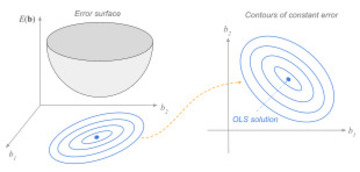

Source: https://allmodelsarewrong.github.io/ridge.html

The constraint in (1) corresponds to a circle whose diameter is influenced by $\lambda$. The solution to the constrained problem is a vector of estimated coefficients that produces a residual sum of squares that is larger than that obtained from the standard unrestricted OLS problem.

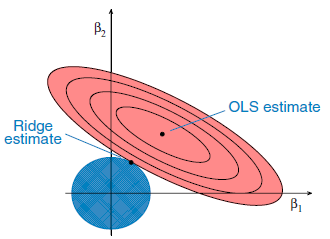

Source: https://online.stat.psu.edu/stat508/lesson/5/5.1

**Observations**:

- Because a general linear or polynomial regression will fail if the independent variables are highly collinear, Ridge regression can be utilized to tackle such situations.

- When we have more parameters than samples,  using Ridge Regression can help.

- The (optimal) value of $\lambda$ is typically obtained using **Cross Validation** ( https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85 , https://scikit-learn.org/stable/modules/cross_validation.html).

### The $\lambda$ parameter

In $L_2$ regularization, the regularization term added to the cost function is $\lambda \sum_{i=1}^{n} \beta^2$, where $\lambda$ is the regularization parameter, and $\beta_i$ are the model parameters. This regularization term penalizes large values of parameters, thereby constraining their magnitude.

When visualizing this in a two-parameter space $(\beta_1, \beta_2)$, the constraint imposed by the $L_2$ norm can be represented as a circle because all points $(\beta_1, \beta_2)$ that satisfy the equation $\beta_1^2 + \beta_2^2 = c$ (for some constant $c$) lie on a circle centered at the origin. This circle represents the boundary within which the parameter values must lie to not incur a penalty larger than a certain threshold.

However, the radius of this circle is not directly proportional to $\lambda$. Instead, the value of $\lambda$ influences the strength of the penalty for parameters being away from zero. A higher $\lambda$ means a stronger penalty for parameters being away from zero, effectively shrinking the coefficients towards zero and making the model simpler (or more regularized).

In the context of the circle analogy, while $\lambda$ itself does not set the radius, it influences how much the model's parameters are constrained in terms of their magnitude. For a given level of regularization (fixed $\lambda$), the optimal parameters $\beta_1, \beta_2$ must lie within a certain distance from the origin, corresponding to a specific "allowable" region under the $L_2$ penalty. The actual "radius" in this analogy corresponds to the maximum allowable magnitude of the parameters before incurring too much penalty, and this threshold is indirectly influenced by $\lambda$, but not in a directly proportional manner. The primary effect of increasing $\lambda$ is to increase the penalty on the magnitude of the parameters, pushing them to be smaller.


### Ridge Regression with Default Parameters

Let's fit a Ridge Regression model to our data:

In [18]:
ridge_model = Ridge() # Creating Ridge Regression model
ridge_model.fit(x_train, y_train) # Fitting the data into the model

Ridge()

And get the performance metrics on our  test data:

In [19]:
ridge_reg = model_performance_regression(ridge_model, x_test, y_test) 
ridge_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144057,2.155826,0.843028,0.842963,19.677968


**Observations:**

- The performance metrics are showing almost similar results as compared to the Least Squares method.

### Ridge Regression with Optimized $\lambda$

Determining the optimal value for $\lambda$ ( or $\alpha$ ) in Ridge Regression is crucial for achieving the best balance between minimizing the residual sum of squares of the model and keeping the model coefficients relatively small to prevent overfitting. The process typically involves the following steps:

1. **Define a Range of $\lambda$ Values**: Start by specifying a range of $\lambda$ values to test. This range should ideally cover several orders of magnitude to explore different levels of regularization strength.

2. **Cross-Validation**: Use cross-validation to evaluate the model performance for each $\lambda$ value. K-fold cross-validation is a common approach, where the data is divided into $k$ subsets, and the model is trained and validated $k$ times, each time using a different subset as the validation set and the remaining as the training set.

3. **Grid Search**: Implement a grid search over the defined range of $\lambda$ values. For each $\lambda$, fit a Ridge Regression model using the training data, apply it to the validation data, and record the model's performance.

4. **Select the Optimal $\lambda$**: After performing cross-validation for each $\lambda$, select the one that offers the best performance according to a pre-defined metric (e.g., mean squared error for regression tasks).

5. **Model Evaluation**: With the optimal $\lambda$ determined, evaluate the Ridge Regression model's performance on a separate test dataset to assess its generalization ability.

Scikit-learn's `RidgeCV` class can automate much of this process by performing cross-validation over a range of $\lambda$ values and selecting the one that minimizes cross-validation error.



In [21]:
# Creating K-Fold Cross-Validation Object
folds = KFold(n_splits=10, shuffle=True, random_state=1)

# Defining Hyperparameters to Tune:
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}

# Initializing the Model:
model = Ridge()

# Setting Up GridSearchCV:
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)

# Fitting the Model:
model_cv.fit(x_train,y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

The optimized $\lambda$ parameter is 0.1.

In [22]:
model_cv.best_params_ #getting optimised parameters for alpha

{'alpha': 0.1}

The following  code will generate a table where each row corresponds to a different $\lambda$ value used during the grid search, alongside the mean R-squared value obtained for that $\lambda$ value. This table allows us to directly compare the performance of different regularization strengths in our Ridge regression model.

In [23]:
# Extracting the cross-validation results into a DataFrame
results = pd.DataFrame(model_cv.cv_results_)

# Selecting the parameters and the mean test score columns
results = results[['param_alpha', 'mean_test_score']]

# Renaming the columns for clarity
results.rename(columns={'param_alpha': 'Lambda (α)', 'mean_test_score': 'R-squared'}, inplace=True)


# Displaying the table
print(results)


  Lambda (α)  R-squared
0      0.001   0.842747
1       0.01   0.842747
2        0.1   0.842747
3        0.2   0.842747
4        0.5   0.842747
5        0.9   0.842747
6          1   0.842747
7          5   0.842746
8         10   0.842743
9         20   0.842730


We can plot the $\lambda$ values against their corresponding R-squared values to visually analyze how the model's performance varies with different regularization strengths. 

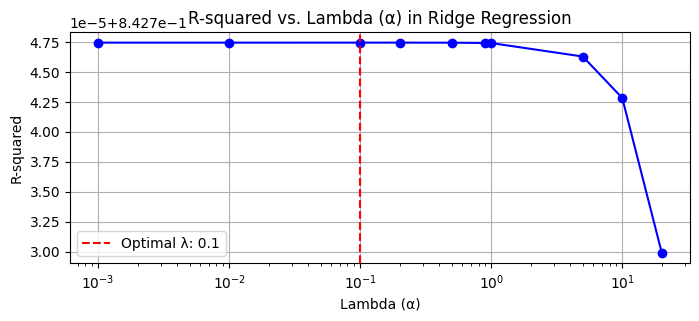

In [24]:
# Converting lambda values from strings to floats for plotting
lambda_values = results['Lambda (α)'].astype(float)

# Finding the optimal lambda value
optimal_lambda = model_cv.best_params_['alpha']

# Plotting
plt.figure(figsize=(8, 3))
plt.plot(lambda_values, results['R-squared'], marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_lambda, color='r', linestyle='--', label=f'Optimal λ: {optimal_lambda}')
plt.title('R-squared vs. Lambda (α) in Ridge Regression')
plt.xlabel('Lambda (α)')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Optional: This scales the x-axis to a logarithmic scale for better visualization
plt.show()


After finding the best value of $\lambda$, we create a **tuned** Ridge Regression Model.

In [20]:
ridge_model_tuned = Ridge(alpha=0.1) ##creating Tuned Ridge Regression model using optimised alpha value
ridge_model_tuned.fit(x_train, y_train) # Fitting the data into the tuned model

Ridge(alpha=0.1)

We can now compare the coefficients of the default and tuned models.

In [21]:
# Extracting the coefficients from both models
coefficients_default = ridge_model.coef_
coefficients_tuned = ridge_model_tuned.coef_

# Creating a DataFrame with feature names
coef_df = pd.DataFrame(index=x_train.columns)

# Adding the coefficients from both models to the DataFrame
coef_df['Default Coefficients'] = coefficients_default
coef_df['Tuned Coefficients'] = coefficients_tuned

# Resetting the index to add the feature names as a column
coef_df.reset_index(inplace=True)
coef_df.rename(columns={'index': 'Feature'}, inplace=True)

# Displaying the table
print(coef_df)


                                  Feature  Default Coefficients  \
0       Available Extra Rooms in Hospital              0.078601   
1                         staff_available             -0.000923   
2                   Visitors with Patient              0.000220   
3                       Admission_Deposit             -0.000038   
4                   Department_anesthesia              6.081468   
5                   Department_gynecology             -3.973756   
6                 Department_radiotherapy             -4.622067   
7                      Department_surgery              6.875058   
8                    Ward_Facility_Code_B             -1.221912   
9                    Ward_Facility_Code_C              0.434354   
10                   Ward_Facility_Code_D             -1.275634   
11                   Ward_Facility_Code_E              0.308281   
12                   Ward_Facility_Code_F             -1.476210   
13                    doctor_name_Dr John              0.23858

Let's export this table to an HTML file:

In [22]:
coef_df.to_html('G:\My Drive\Cursos_USM\Supervised Machine Learning\Output/coef_df.html')
print("DataFrame has been exported to 'coef_df.html'.")

DataFrame has been exported to 'coef_df.html'.


As can be seen, both set of estimated coefficients are almots identycal. Finally, we obtain the performance metrics of the tuned model in the test data set.

In [23]:
ridge_reg_tuned = model_performance_regression(ridge_model_tuned, x_test, y_test) #getting performance metrics on test data
ridge_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155771,0.843028,0.842964,19.677066


**Observations:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.1.
- It can be observed that after tuning the parameters of Ridge Regression, the performance parameters does not change implying that Ridge Regression does not help in improving the model.
- Furthermore, and not surprisingly, the coefficients of the default and tuned models are almost identical.

## LASSO (Least Absolute Shrinkage and Selection Operator) Regression ($L_1$ Regularization)

**Lasso regression** is another regularisation technique for reducing model complexity. 
It is identical to Ridge Regression except that the penalty term only contains absolute weights rather than a square of weights.

The $L_1$ penalty is the sum of the absolute values of the coefficients, mathematically defined as:

$$
\text{$L_1$ penalty} = \lambda \sum_{j=1}^{k} | \beta_j |
$$

where $\beta_j$ represents the coefficient of the $j^{th}$ predictor, $k$ is the total number of predictors, and $\lambda$ is the regularization parameter. Accordingly, the LASSO estimator $\hat{\beta}_{LASSO}$  solves the following minimization problem:

\begin{equation}

Min\sum_{i=1}^n (y_i - \sum_{j=1}^k x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^{k} | \beta_j |

\end{equation} 

Differently from a ridge solution, which can sometimes be hard to interpret, particullarly in high dimensional problems, the $L_1$ regularization can lead to some coefficients being exactly zero, providing a sparse solution conducive to **feature selection**. For $k=2$, the problem in (1) can be characterized geometrically:

Interestingly, using LASSO, we can have the following situation, which leads to variable selection and sparser models:

### Lasso Regression with Default Parameters

In [24]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)

Lasso()

In [25]:
lasso_reg = model_performance_regression(lasso_model, x_test, y_test)
lasso_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.064339,3.873332,0.416006,0.415766,34.652716


**Observations:**

- After fitting the data into Lasso Regression Model with default value of $\lambda=1$ (or $\alpha$), the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.
- We can tune the $\lambda$ to get the optimized value using `Grid SearchCV`.

### Lasso Regression with optimized $\lambda$

In [31]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [32]:
model_cv.best_params_

{'alpha': 0.001}

**Observations**:

* In this case, the optimal value of $\lambda$ is at the lower limit of the grid. In such a case, it is a good idea to check whether smaller values improve the test results.

In [40]:
# This will take a while to run....

folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.00001, 0.00005]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(), param_grid={'alpha': [1e-05, 5e-05]},
             return_train_score=True, scoring='r2')

In [41]:
model_cv.best_params_

{'alpha': 1e-05}

**Observations**:

* We keep *bouncing* against the lower limit of the grid even with very small values for $\lambda$. 

* Since the value of $\lambda$ influences the strength of the penalty for parameters being away from zero, a lower $\lambda$ means a weaker penalty for parameters being away from zero.

* This suggests that the optimal fit only involves a small amount of shrinkage relative to the least square solution.

Let's generate a table with the different $\lambda$ values and their corresponding mean R-squared. We will also generate the associated plot.

In [47]:
# This will take a while to run....

folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.00001, 0.0001,0.001,0.01,0.1,1]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='r2')

In [48]:
results = pd.DataFrame(model_cv.cv_results_)
results = results[['param_alpha', 'mean_test_score']]
results.rename(columns={'param_alpha': 'Lambda (α)', 'mean_test_score': 'R-squared'}, inplace=True)
print(results)

  Lambda (α)  R-squared
0    0.00001   0.842748
1     0.0001   0.842747
2      0.001   0.842738
3       0.01   0.842029
4        0.1   0.798587
5          1   0.417511


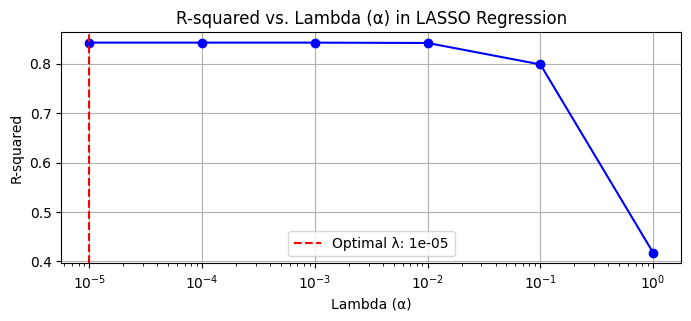

In [49]:
lambda_values = results['Lambda (α)'].astype(float)

optimal_lambda = model_cv.best_params_['alpha']

# Plotting
plt.figure(figsize=(8, 3))
plt.plot(lambda_values, results['R-squared'], marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_lambda, color='r', linestyle='--', label=f'Optimal λ: {optimal_lambda}')
plt.title('R-squared vs. Lambda (α) in LASSO Regression')
plt.xlabel('Lambda (α)')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Optional: This scales the x-axis to a logarithmic scale for better visualization
plt.show()

We get similar results. What if we choose a different fit metric? For instance, the MAE is less sensitive to outliers compared to R-squared.

In [ ]:
# This will take a while to run....

folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.00001, 0.0001,0.001,0.01,0.1,1]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_error', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [51]:
model_cv.best_params_

{'alpha': 1e-05}

In [55]:
results = pd.DataFrame(model_cv.cv_results_)
results = results[['param_alpha', 'mean_test_score']]
results.rename(columns={'param_alpha': 'Lambda (α)', 'mean_test_score': '(neg) MAE'}, inplace=True)

print(results)

  Lambda (α)  (neg) MAE
0    0.00001  -2.146582
1     0.0001  -2.146748
2      0.001  -2.147923
3       0.01  -2.164396
4        0.1  -2.506707
5          1  -3.854096


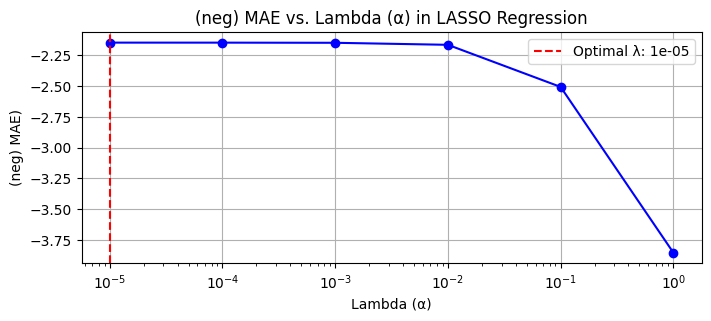

In [59]:
lambda_values = results['Lambda (α)'].astype(float)
optimal_lambda = model_cv.best_params_['alpha']

# Plotting
plt.figure(figsize=(8, 3))
plt.plot(lambda_values, results['(neg) MAE'], marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_lambda, color='r', linestyle='--', label=f'Optimal λ: {optimal_lambda}')
plt.title('(neg) MAE vs. Lambda (α) in LASSO Regression')
plt.xlabel('Lambda (α)')
plt.ylabel('(neg) MAE)')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Optional: This scales the x-axis to a logarithmic scale for better visualization
plt.show()

Again, very small values of $\lambda$ seem to be optimal.

After deciding on the best value of $\lambda$, we create a **tuned** LASSO Regression Model. A value of $\lambda$ of 0.001 seems to be a reasonable choice:

In [26]:
lasso_model_tuned = Lasso(alpha=0.001)
lasso_model_tuned.fit(x_train, y_train)

Lasso(alpha=0.001)

It will be interesting to compare the coefficients of the default ($\lambda=1$) and tuned models ($\lambda=0.001$).

In [27]:
# Extracting the coefficients from both models
coefficients_default = lasso_model.coef_
coefficients_tuned = lasso_model_tuned.coef_

# Creating a DataFrame with feature names
coef_df = pd.DataFrame(index=x_train.columns)

# Adding the coefficients from both models to the DataFrame
coef_df['Default Coefficients'] = coefficients_default
coef_df['Tuned Coefficients'] = coefficients_tuned

# Resetting the index to add the feature names as a column
coef_df.reset_index(inplace=True)
coef_df.rename(columns={'index': 'Feature'}, inplace=True)

# Displaying the table
print(coef_df)


                                  Feature  Default Coefficients  \
0       Available Extra Rooms in Hospital              0.000000   
1                         staff_available              0.000000   
2                   Visitors with Patient              0.000000   
3                       Admission_Deposit              0.000196   
4                   Department_anesthesia              0.000000   
5                   Department_gynecology             -7.291335   
6                 Department_radiotherapy             -0.000000   
7                      Department_surgery              0.000000   
8                    Ward_Facility_Code_B             -0.000000   
9                    Ward_Facility_Code_C              0.000000   
10                   Ward_Facility_Code_D             -0.000000   
11                   Ward_Facility_Code_E              0.000000   
12                   Ward_Facility_Code_F             -0.000000   
13                    doctor_name_Dr John              0.00000

For better visualization, we can export the table to html.

In [28]:
coef_df.to_html('G:\My Drive\Cursos_USM\Supervised Machine Learning\Output/coef_df_LASSO.html')
print("DataFrame has been exported to 'coef_df_LASSO.html'.")

DataFrame has been exported to 'coef_df_LASSO.html'.


**Observations**: 

* With $\lambda=1$, too much penalty was imposed on the size of the coefficients, resulting in many coefficients being set to zero.

* As a result, a lot of bias was introduced into the model, resulting in poor performance.

Finally, we obtain the performance metrics of the tuned model in the test data set.

In [29]:
lasso_reg_tuned = model_performance_regression(lasso_model_tuned, x_test, y_test)
lasso_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144315,2.157198,0.843002,0.842938,19.702959


**Observation:**

- The performance metrics are showing similar results as compared to Least Squares method and Ridge Regression, implying that after adding the penalty, the model does not improve.

## Elastic Net Regression

**Elastic Net** (https://www.sciencedirect.com/topics/mathematics/elastic-net,  https://machinelearningcompass.com/machine_learning_models/elastic_net_regression/) is a regularized regression model that combines $L_1$ and $L_2$ penalties, i.e., **LASSO** and **Ridge** regression. As a result, it performs a more efficient smoothing process.

Elastic Net Regression is a linear regression model that combines the penalties of the Ridge and Lasso regression methods. It is particularly useful when there are multiple features correlated with each other. In such cases, Lasso might select only one variable from a group of correlated variables, while Ridge might include all, but not necessarily with the significance needed for model interpretation. Elastic Net aims to balance out these aspects by blending the penalties of Ridge and Lasso, potentially providing a model that maintains a good balance between feature selection and regularization.

The cost function for Elastic Net Regression as a minimization problem is formulated to combine the regularization properties of both Ridge (L2 norm) and Lasso (L1 norm) regression. It aims to minimize the following objective function:

$$
\text{Minimize} \, J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - x_i^T \beta)^2 + \lambda_1 \sum_{j=1}^{k} |\beta_j| + \frac{\lambda_2}{2} \sum_{j=1}^{k} \beta_j^2
$$

where $\beta_j$ represents the coefficient of the $j^{th}$ predictor, $k$ is the total number of predictors, $\lambda_1$ is the weighting of the L1 penalty (Lasso), and $\lambda_2$ is the weighting of the L2 penalty (Ridge).

The first term in this function is the Residual Sum of Squares (RSS), which measures the fit of the model to the data. The second term is the L1 penalty, which promotes sparsity in the coefficients (leading to feature selection). The third term is the L2 penalty, which encourages the shrinkage of the coefficients and helps to deal with multicollinearity by ensuring the coefficients stay relatively small and more stable.

Elastic Net allows for a trade-off between Lasso and Ridge regularization, controlled by the parameters $\lambda_1$ and $\lambda_2$. In practice, these parameters are chosen through a process such as cross-validation to optimize the model's performance on unseen data, balancing the bias-variance trade-off.


### The $L_1$ Ratio Parameter

When incorporating the $L_1$ ratio parameter into the Elastic Net Regression cost function, the formulation adjusts to balance the mix of $L_1$ and $L_2$ penalties based on a single parameter, often denoted as $\alpha$ for the overall strength of the regularization and $l1\_ratio$ for the mix between $L_1$ and $L_2$ penalties. The cost function can be expressed as:

$$
\text{Minimize} \, J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - x_i^T \beta)^2 + \alpha \cdot l1\_ratio \sum_{j=1}^{k} |\beta_j| + \frac{\alpha \cdot (1 - l1\_ratio)}{2} \sum_{j=1}^{k} \beta_j^2
$$

where $\alpha$ is the parameter that controls the overall strength of the regularization and $l1\_ratio$ is the Elastic Net mixing parameter, with a value between 0 and 1. 

* $l1\_ratio = 1$ corresponds to Lasso regression (pure $L_1$ norm penalty)

* $l1\_ratio = 0$ corresponds to Ridge regression (pure $L_2$ norm penalty)


This formulation allows for a continuous transition between Lasso and Ridge regression, enabling the model to inherit the benefits of both methods depending on the choice of $l1\_ratio$. The parameters $\alpha$ and $l1\_ratio$ are typically selected through cross-validation to find the best trade-off between underfitting and overfitting for a given dataset.

### Elastic Net Regression with Default Parameters

In [35]:
elasticnet_model = ElasticNet()
elasticnet_model.fit(x_train, y_train)

ElasticNet()

In [36]:
elasticnet_reg = model_performance_regression(elasticnet_model, x_test, y_test)
elasticnet_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.556087,4.678504,0.317455,0.317175,40.121657


**Observations:**

- After fitting the data into Elastic Net Model with default value of $\alpha=1$ and $l1\_ratio=0.5$, the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.
- We can tune these parameters to get the optimized value similar to Ridge Regression using `Grid SearchCV`.

### Elastic Net Regression with optimized $\alpha$ and $L_1-ratio$

In this case, the `param_grid` specifies two parameters to be tested — $\alpha$ for the amount of regularization and the *$l1\_ratio$* for the mix between L1 and L2 regularization. 

In [47]:
# This will take a while to run....seriously!!!!

folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
         'l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
model = ElasticNet()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             return_train_score=True, scoring='r2')

In [48]:
model_cv.best_params_

{'alpha': 0.001, 'l1_ratio': 0.9}

To generate a summary table with the columns $\alpha$, $l1\_ratio$, and the corresponding *R-squared* value from the GridSearchCV results on an ElasticNet model, we'll need to extract these details from the `cv_results_` attribute of the `model_cv` object after fitting the model.

In [49]:
# Extract the parameters and corresponding mean test scores from the cv_results_
results_df = pd.DataFrame(model_cv.cv_results_)

# Select the columns of interest: 'param_alpha', 'param_l1_ratio', and 'mean_test_score'
summary_df = results_df[['param_alpha', 'param_l1_ratio', 'mean_test_score']]

# Rename the columns for clarity
summary_df.columns = ['Alpha', 'L1_Ratio', 'R_squared']

# Optionally, you can sort the dataframe based on R_squared values to see the best performing parameters at the top
summary_df = summary_df.sort_values(by='R_squared', ascending=False)

# Display the summary table
print(summary_df)


    Alpha L1_Ratio  R_squared
8   0.001      0.9   0.842701
7   0.001      0.8   0.842584
6   0.001      0.7   0.842436
5   0.001      0.6   0.842275
4   0.001      0.5   0.842111
3   0.001      0.4   0.841947
2   0.001      0.3   0.841785
1   0.001      0.2   0.841628
0   0.001      0.1   0.841476
17   0.01      0.9   0.840192
16   0.01      0.8   0.838435
15   0.01      0.7   0.836979
14   0.01      0.6   0.835611
13   0.01      0.5   0.834277
12   0.01      0.4   0.832948
11   0.01      0.3   0.831638
10   0.01      0.2   0.830337
9    0.01      0.1   0.829004
26    0.1      0.9   0.778532
25    0.1      0.8   0.766218
24    0.1      0.7   0.755750
23    0.1      0.6   0.746831
22    0.1      0.5   0.738944
21    0.1      0.4   0.731901
20    0.1      0.3   0.725666
19    0.1      0.2   0.719978
18    0.1      0.1   0.714735
35    0.2      0.9   0.695250
34    0.2      0.8   0.682896
33    0.2      0.7   0.672020
32    0.2      0.6   0.663652
31    0.2      0.5   0.657241
30    0.2 

We next obtain the fit metrics for the model in  test data set:

In [55]:
elasticnet_model_tuned = ElasticNet(alpha=0.001, l1_ratio=0.9)
elasticnet_model_tuned.fit(x_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.9)

In [56]:
elasticnet_reg_tuned = model_performance_regression(elasticnet_model_tuned, x_test, y_test)
elasticnet_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144768,2.159282,0.842957,0.842892,19.736774


Let's obtain the estimated coefficients of the default and tuned models:

In [57]:

coefficients_default = elasticnet_model.coef_
coefficients_tuned = elasticnet_model_tuned.coef_

# Creating a DataFrame with feature names
coef_df = pd.DataFrame(index=x_train.columns)

# Adding the coefficients from both models to the DataFrame
coef_df['Default Coefficients'] = coefficients_default
coef_df['Tuned Coefficients'] = coefficients_tuned

# Resetting the index to add the feature names as a column
coef_df.reset_index(inplace=True)
coef_df.rename(columns={'index': 'Feature'}, inplace=True)

# Displaying the table
print(coef_df)

                                  Feature  Default Coefficients  \
0       Available Extra Rooms in Hospital             -0.000000   
1                         staff_available              0.000000   
2                   Visitors with Patient              0.000000   
3                       Admission_Deposit              0.000246   
4                   Department_anesthesia              1.003870   
5                   Department_gynecology             -2.352968   
6                 Department_radiotherapy              0.000000   
7                      Department_surgery              0.000000   
8                    Ward_Facility_Code_B             -0.039621   
9                    Ward_Facility_Code_C              0.000000   
10                   Ward_Facility_Code_D             -0.134357   
11                   Ward_Facility_Code_E              0.627396   
12                   Ward_Facility_Code_F             -0.178972   
13                    doctor_name_Dr John              0.18054

In [58]:
coef_df.to_html('G:\My Drive\Cursos_USM\Supervised Machine Learning\Output/coef_df_Elastic.html')
print("DataFrame has been exported to 'coef_df_Elastic.html'.")

DataFrame has been exported to 'coef_df_Elastic.html'.


**Observation**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001, and l1_ratio = 0.05.
- The performance metrics are showing almost similar results as compared to Least Squares method, Ridge Regression and Lasso Regression, implying that after tuning the Elastic Net, the model does not improve.

In [59]:
models= pd.concat([linear_reg_test,ridge_reg,ridge_reg_tuned,lasso_reg,lasso_reg_tuned,elasticnet_reg,
                   elasticnet_reg_tuned], axis=0) #combining all models into a single dataframe
models['Models'] = ['Least Squares', 'Ridge Regression', 'Ridge Regression Tuned', 'Lasso Regression',
                                      'Lasso Regression Tuned', 'Elastic Net Regression',
                    'Elastic Net Regression Tuned'] #adding names of the models as a column to the dataframe
models = models.iloc[:,[5, 0,1,2,3,4]] #ordering names of the models as the first column
models

,Models,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Least Squares,3.144055,2.155765,0.843028,0.842964,19.676966
0,Ridge Regression,3.144057,2.155826,0.843028,0.842963,19.677968
0,Ridge Regression Tuned,3.144055,2.155771,0.843028,0.842964,19.677066
0,Lasso Regression,6.064339,3.873332,0.416006,0.415766,34.652716
0,Lasso Regression Tuned,3.144315,2.157198,0.843002,0.842938,19.702959
0,Elastic Net Regression,6.556087,4.678504,0.317455,0.317175,40.121657
0,Elastic Net Regression Tuned,3.144768,2.159282,0.842957,0.842892,19.736774


**Observations:**

- As per the above result, the **Least Squares Method** is giving the best results as compared to other models.
- Regularization technique does not offer any significant improvement to the performance metrics.
- So, we will apply some **Non Linear models** to check if the model performance improves or not.